In [1]:
import glob
import numpy as np
import gensim
from random import sample
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import logging

logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO
)

print('Fast version? (1 for yes) {}'.format(gensim.models.word2vec.FAST_VERSION))

Fast version? (1 for yes) 1


## Plan
1. Class to read in data
1. Train word embedding model
1. Get ground truth
1. Classify

In [4]:
class ReviewGetter(object):
    """
    This class iterates through reviews
    
    - Store input paths on the class
    
    - The __iter__ method, each time called, will run through the docs again
      We need to iterate a bunch of times so this makes sense
    
    - On the first pass, we save the ground truth labels on the class
    
    - Also on first pass, we save word counts
      Word probabilities will be important later
    """
    BASE_FOLDER = 'review_polarity/txt_sentoken'
    PATHS = {
        'pos': glob.glob(BASE_FOLDER + '/pos/*.txt'),
        'neg': glob.glob(BASE_FOLDER + '/neg/*.txt'),
    }
    
    def __init__(self):
        self.n_reviews = 0
        self.word_count_dict = {}
        self.first_run = True
    
    def get_reviews(self):
        """
        - Will iterate through the docs each time called
        
        - Yields a list of tokens
        - We do one preprocessing step,
          adding <b> at the beginning and </b> at the end of a review
          plus adding <s> between sentences
        
        Example use:
        r = ReviewIterator()
        for review in r:
            do_stuff(review)
        """
        count = 0

        reviews = []
        
        for label, paths in self.PATHS.items():
            if label == 'pos':
                valence = 1
            else:
                valence = 0
            for path in paths:             
                with open(path, 'r') as infile:
                    review = []
                    for line in infile:
                        review.extend(line.split() + ['<s>'])
                        # bookkeeping
                    count += 1
                    if count % 500 == 0:
                        logging.info('Yielded {} reviews'.format(count))
                    if self.first_run == True:
                        self.n_reviews += 1
                        for word in review:
                            try:
                                self.word_count_dict[word] += 1
                            except:
                                self.word_count_dict[word] = 1
                    reviews.append((valence, review))
        self.first_run = False
        return reviews

## Simple diagnostics

In [5]:
r = ReviewGetter()

data = r.get_reviews()

reviews = [x[1] for x in data]

2017-05-03 13:19:27,971 : INFO : Yielded 500 reviews
2017-05-03 13:19:28,241 : INFO : Yielded 1000 reviews
2017-05-03 13:19:28,429 : INFO : Yielded 1500 reviews
2017-05-03 13:19:28,610 : INFO : Yielded 2000 reviews


In [6]:
len(reviews)
print(reviews[1][:50])

['every', 'now', 'and', 'then', 'a', 'movie', 'comes', 'along', 'from', 'a', 'suspect', 'studio', ',', 'with', 'every', 'indication', 'that', 'it', 'will', 'be', 'a', 'stinker', ',', 'and', 'to', "everybody's", 'surprise', '(', 'perhaps', 'even', 'the', 'studio', ')', 'the', 'film', 'becomes', 'a', 'critical', 'darling', '.', '<s>', 'mtv', "films'", '_election', ',', 'a', 'high', 'school', 'comedy', 'starring']


## Word2Vec happens here

In [7]:
w2v_model = gensim.models.Word2Vec(
    sample(reviews, len(reviews)),
    iter=30, # number of algorithm iterations
    seed=42,
    workers=2, # number of CPU cores to use
    size=100, # length of each word vector
    sample=1e-4, # if word has p>sample, downsample it
    window=10, # window on sides of focal word
)

2017-05-03 13:19:31,098 : INFO : collecting all words and their counts
2017-05-03 13:19:31,099 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-03 13:19:31,429 : INFO : collected 50921 word types from a corpus of 1557401 raw words and 2000 sentences
2017-05-03 13:19:31,430 : INFO : Loading a fresh vocabulary
2017-05-03 13:19:31,512 : INFO : min_count=5 retains 15284 unique words (30% of original 50921, drops 35637)
2017-05-03 13:19:31,513 : INFO : min_count=5 leaves 1499751 word corpus (96% of original 1557401, drops 57650)
2017-05-03 13:19:31,559 : INFO : deleting the raw counts dictionary of 50921 items
2017-05-03 13:19:31,561 : INFO : sample=0.0001 downsamples 353 most-common words
2017-05-03 13:19:31,562 : INFO : downsampling leaves estimated 683187 word corpus (45.6% of prior 1499751)
2017-05-03 13:19:31,563 : INFO : estimated required memory for 15284 words and 100 dimensions: 19869200 bytes
2017-05-03 13:19:31,617 : INFO : resetting layer weight

## W2V diagnostics

We should pick some words and make sure their synonyms make sense to us

In [8]:
w2v_model.wv.most_similar(positive=['woman'])
w2v_model.wv.most_similar(positive=['man'], negative=['king'])
w2v_model.wv.most_similar(positive=['spielberg'])
w2v_model.wv.most_similar(positive=['spielberg', 'tarantino'])


2017-05-03 13:20:06,051 : INFO : precomputing L2-norms of word weight vectors


[('quentin', 0.7592371106147766),
 ('masterpiece', 0.6866481304168701),
 ("spielberg's", 0.6368312835693359),
 ('fiction', 0.6258630752563477),
 ('jules', 0.6246006488800049),
 ("tarantino's", 0.6116619110107422),
 ('pulp', 0.6040959358215332),
 ('directing', 0.6025127172470093),
 ('zwick', 0.6019469499588013),
 ('masses', 0.6017510294914246)]

## Combine to make review vectors

We use a really simple method:
1. Choose an `alpha` level (lit indicates 0.001 to 0.0001, but for our task a value of 1 works best)
1. For each word a person uses, get the word vector `v_word`
1. Weight `v_word` by its overall frequency in the corpus `p_word` using formula `alpha / (alpha + p_word)` to get `v_word_weighted`. This downweights the impact of common words. A smaller `alpha` makes this downweighting more severe.
1. Add `v_word_weighted` to the user vector `v_user` (which we initialize as all 0's.
1. To account for different activity levels of different users, after we are done adding `v_word_weighted` for all words a user has used, we divide `v_user` by `n_words_user` to get our final user vector

In [9]:
word_vectors = w2v_model.wv

word_vocab_dict = w2v_model.wv.vocab
word_count_dict = r.word_count_dict

word_prob_dict = {k: word_count_dict[k] for k in word_vocab_dict.keys()}
word_count_sum = sum(word_prob_dict.values())
word_prob_dict = {k: v / word_count_sum for k, v in word_prob_dict.items()}

review_token_counts = np.zeros((2000,))
review_vectors = np.zeros((2000, 100))

a = 1

for idx, (label, review_tokens) in enumerate(data):
    for token in review_tokens:
        if token in word_vectors:
            p = word_prob_dict[token]
            review_token_counts[idx] += 1
            review_vectors[idx] += (a / (a + p)) * word_vectors[token]

review_vectors = review_vectors / review_token_counts[:,None]

## Model and evaluate

### Model

Logistic regression with L2 penalty ("Ridge").

This penalizes the L2-norm of the coefficient vector.

L2 logistic regression is the most common way I've seen of summarizing word vectors. They seem to do well with "dense vectors" (e.g. not many 0's).

### Metrics

1. Accuracy: What fraction of predictions are correct?
1. Precision: What fraction of classified 1's are true 1's?
1. Recall: What fraction of true 1's are actually predicted 1's from the classifier?
1. F1: Harmonic mean of Precision and Recall (`2 * (p*r) / (p + r)`)
1. AUC: Area under the receiver operating characteristic (ROC) curve. We show a plot below because this is an important measure.

In [10]:
X = review_vectors
y = np.array([x[0] for x in data])

clf = LogisticRegression(penalty='l2')

kf = KFold(n_splits=5, shuffle=True)

scores = {
    'acc': [],
    'prec': [],
    'rec': [],
    'f1': [],
    'auc': [],
}

# n by 2 vector, holding probabilities for 1's and 0's
out_of_bag_probs = np.zeros((r.n_reviews, 2))

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)
    
    out_of_bag_probs[test_idx] = y_probs
    
    scores['acc'].append(accuracy_score(y_test, y_pred))
    scores['prec'].append(precision_score(y_test, y_pred))
    scores['rec'].append(recall_score(y_test, y_pred))
    scores['f1'].append(f1_score(y_test, y_pred))
    scores['auc'].append(roc_auc_score(y_test, y_probs[:,1]))
    
for metric, scores in scores.items():
    print('{} = {}'.format(metric, np.mean(scores)))

acc = 0.8305
prec = 0.8352092557309087
rec = 0.8228884245924271
f1 = 0.8289623758992128
auc = 0.9136201030879427


## ^ These results are pretty good

As a comparison, the paper these data come from achieved a max accuracy of 87.2%. That paper had domain specific knowledge and a careful modeling procedure.

We have some w2v code and no domain knowledge. We could imagine many improvements (doc vecs, tuning parameters, incorporating additional word-based signals, etc.).

#### A simple way to increase accuracy is to increase `iter` in the w2v model.

### Bonus content: plot the ROC curve

Intuition: if we can get a predicted probability of being in each class, we can vary our cutoff (e.g. label `x > .3` as 1, `x > .4` as 1, etc.).

When we vary the cutoff, the true positive rate (TPR) and false positive rate (FPR) of the 1's will change.

At low cutoffs, we will get more of the true 1's, but will also have more 0's erroneously classified as 1's.

AUC-ROC lets us visually investigate this and choose an optimal cutoff. It also lets us see how well our classifier performs across cutoff levels.

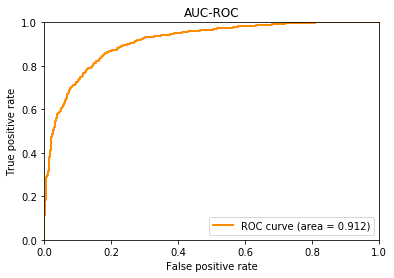

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
%matplotlib inline

fpr, tpr, _ = roc_curve(y, out_of_bag_probs[:,1])
auc = roc_auc_score(y, out_of_bag_probs[:,1])

plt.figure()
plt.plot(
    fpr,
    tpr,
    color='darkorange',
    lw=2,
    label='ROC curve (area = {0:.3f})'.format(auc))

plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC-ROC')
plt.legend(loc='lower right')
plt.show()